<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.19.0

numpy      : 1.19.2
scipy      : 1.5.2
pandas     : 1.2.1
matplotlib : 3.3.2
statsmodels: 0.12.1
sklearn    : 0.23.2

Compiler    : Clang 4.0.1 (tags/RELEASE_401/final)
OS          : Darwin
Release     : 15.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Git hash: a3684aeb1fe0c220386edfc01b7e094c5dce067b



In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [2]:
PATH_TO_DATA = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 
                                            '.', 'hw06', 'capstone_user_identification'))

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [9]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [4]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [3]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [4]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1).fit(X_train, y_train)
train_score = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1).mean()
valid_score = knn.score(X_valid, y_valid)

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [10]:
print(f'{train_score:.3f} {valid_score:.3f}')

0.559 0.584


**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
forest = RandomForestClassifier(n_estimators=100,
                oob_score=True, random_state=17, n_jobs=-1).fit(X_train, y_train)
oob_score = forest.oob_score_
valid_score = forest.score(X_valid, y_valid)

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [13]:
with open('answer4_2.txt', 'w') as f:
    print(f'{oob_score:.3f} {valid_score:.3f}', file=f)

In [30]:
!cat answer4_2.txt

0.717 0.731


**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [5]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [11]:
logit = LogisticRegression(random_state=17, n_jobs=-1).fit(X_train, y_train)
train_score = cross_val_score(logit, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1).mean()
valid_score = logit.score(X_valid, y_valid)
print(f'{train_score:.3f} {valid_score:.3f}')

0.761 0.777


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [16]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(multi_class='multinomial', scoring='accuracy',
                                    Cs=logit_c_values1, cv=skf, random_state=17, n_jobs=-1)
logit_grid_searcher1 = logit_grid_searcher1.fit(X_train, y_train)

Wall time: 7.83 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [17]:
logit_mean_cv_scores1 = np.apply_along_axis(np.mean, 0,
            logit_grid_searcher1.scores_[logit_grid_searcher1.classes_[0]])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [18]:
best_idx = np.argmax(logit_mean_cv_scores1)
print(f'best score: {logit_mean_cv_scores1[best_idx]:.3f}',
      f'C: {logit_grid_searcher1.Cs_[best_idx]:.3f}')

best score: 0.761 C: 1.000


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

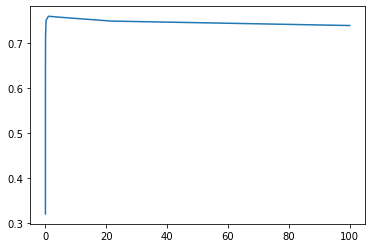

In [19]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [12]:
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(multi_class='multinomial', scoring='accuracy',
                                    Cs=logit_c_values2, cv=skf, random_state=17, n_jobs=-1)
logit_grid_searcher2 = logit_grid_searcher2.fit(X_train, y_train)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [13]:
logit_mean_cv_scores2 = np.apply_along_axis(np.mean, 0,
            logit_grid_searcher2.scores_[logit_grid_searcher2.classes_[0]])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [14]:
best_idx = np.argmax(logit_mean_cv_scores2)
logit_best_c = logit_grid_searcher2.Cs_[best_idx]
print(f'best score: {logit_mean_cv_scores2[best_idx]:.3f}',
      f'C: {logit_best_c:.3f}')

best score: 0.761 C: 1.916


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

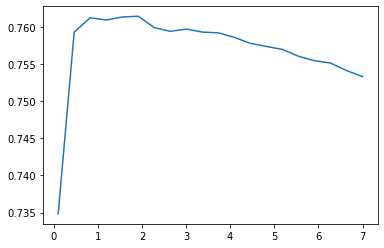

In [23]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [24]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [25]:
print(f'{logit_mean_cv_scores2[best_idx]:.3f} {logit_cv_acc:.3f}')

0.761 0.780


**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [24]:
from sklearn.svm import LinearSVC

In [25]:
svm = LinearSVC(C=1, random_state=17).fit(X_train, y_train)
train_score = cross_val_score(svm, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1).mean()
valid_score = svm.score(X_valid, y_valid)
print(f'{train_score:.3f} {valid_score:.3f}')

0.751 0.777


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [28]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1, scoring='accuracy', cv=skf,
                                  return_train_score=True, n_jobs=-1)
svm_grid_searcher1 = svm_grid_searcher1.fit(X_train, y_train)

Wall time: 10 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [29]:
print(f'score: {svm_grid_searcher1.best_score_:.3f}',
      f'C: {int(svm_grid_searcher1.best_params_["C"])}')

score: 0.696 C: 5555


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

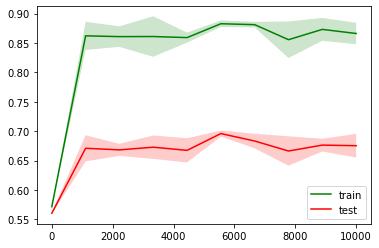

In [30]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [31]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2, scoring='accuracy', cv=skf,
                                  return_train_score=True, n_jobs=-1)
svm_grid_searcher2 = svm_grid_searcher2.fit(X_train, y_train)

Wall time: 14.8 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [32]:
print(f'score: {svm_grid_searcher2.best_score_:.3f}',
      f'C: {svm_grid_searcher2.best_params_["C"]:.2f}')

score: 0.767 C: 0


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

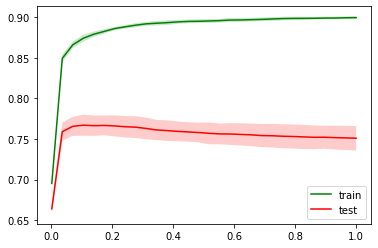

In [33]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [34]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [35]:
print(f'{svm_grid_searcher2.best_score_:.3f} {svm_cv_acc:.3f}')

0.767 0.781


## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [6]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    with open(path_to_X_pickle, 'rb') as X_pkl:
        X = pickle.load(X_pkl)
    
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
        
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, 
                                                     random_state=random_state, stratify=y)
    train_score = cross_val_score(estimator, X_train, y_train, cv=cv, scoring='accuracy',
                                 n_jobs=-1).mean()
    valid_score = accuracy_score(y_valid, estimator.predict(X_valid))
    return train_score, valid_score

**Убедитесь, что функция работает.**

In [37]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7670206386611259, 0.7807537331121118)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [95]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [38]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        start = time()
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 
                    f'X_sparse_10users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 
                    f'y_10users_s{session_length}_w{window_size}.pkl')
        train_score, valid_score = model_assessment(estimator, path_to_X_pkl,
                                                    path_to_y_pkl, skf)
        print(f's{session_length}\tw{window_size}\t',
              f'scores: {train_score:.3f} {valid_score:.3f}\t',
              f'{time() - start:.1f}s')

s15	w10	 scores: 0.781 0.814	 0.7s
s10	w10	 scores: 0.767 0.781	 0.3s
s15	w7	 scores: 0.795 0.838	 0.9s
s10	w7	 scores: 0.759 0.797	 0.5s
s7	w7	 scores: 0.755 0.796	 0.3s
s15	w5	 scores: 0.829 0.846	 1.2s
s10	w5	 scores: 0.758 0.791	 0.7s
s7	w5	 scores: 0.732 0.764	 0.5s
s5	w5	 scores: 0.725 0.761	 0.2s
Wall time: 5.17 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [39]:
train_score, valid_score = model_assessment(estimator, 
            os.path.join(PATH_TO_DATA, 'X_sparse_10users_s15_w5.pkl'),
            os.path.join(PATH_TO_DATA, 'y_10users_s15_w5.pkl'), skf)
print(f'{train_score:.3f} {valid_score:.3f}')

0.829 0.846


наибольшую точность показывает длина сессии 15, с наиболее удачной комбинацией с окном 5 

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [26]:
svm = svm.fit(X_train_150, y_train_150)

In [27]:
svm_params3 = {'C': [0.1]}
svm_grid_searcher3 = GridSearchCV(svm, svm_params3,
            scoring='accuracy', cv=skf, return_train_score=True,
            n_jobs=-1).fit(X_train_150, y_train_150)
estimator = svm_grid_searcher3.best_estimator_

In [56]:
print(f'score: {svm_grid_searcher3.best_score_:.3f}',
      f'C: {svm_grid_searcher3.best_params_["C"]:.2f}')

score: 0.463 C: 0.10


In [59]:
%%time
for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        start = time()
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 
                f'X_sparse_150users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 
                f'y_150users_s{session_length}_w{window_size}.pkl')
        train_score, valid_score = model_assessment(estimator, path_to_X_pkl, 
                                                path_to_y_pkl, skf)
        print(f's{session_length}\tw{window_size}\t',
              f'scores: {train_score:.3f} {valid_score:.3f}\t',
              f'{time() - start:.1f}s')

s15	w10	 scores: 0.482 0.565	 122.3s
s10	w10	 scores: 0.463 0.484	 66.9s
s15	w7	 scores: 0.508 0.559	 207.1s
s10	w7	 scores: 0.455 0.526	 119.5s
s7	w7	 scores: 0.436 0.515	 68.3s
s15	w5	 scores: 0.535 0.557	 302.3s
s10	w5	 scores: 0.459 0.504	 198.5s
s7	w5	 scores: 0.417 0.465	 113.4s
s5	w5	 scores: 0.408 0.458	 72.4s
Wall time: 21min 10s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [58]:
train_score, valid_score = model_assessment(estimator, 
            os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'),
            os.path.join(PATH_TO_DATA, 'y_150users.pkl'), skf)
print(f'{train_score:.3f} {valid_score:.3f}')

0.463 0.484
Wall time: 1min 8s


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [7]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
     y_150users = pickle.load(y_150users_pkl)

In [8]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                    y_150users, test_size=0.3, random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [15]:
%%time
logit_cv_150users = LogisticRegressionCV(multi_class='ovr', scoring='accuracy',
        Cs=[logit_best_c], cv=skf, random_state=17, n_jobs=-1).fit(X_train_150, y_train_150)

CPU times: user 8min 7s, sys: 8.11 s, total: 8min 15s
Wall time: 9min 13s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [16]:
user_scores = {}

for user_id in logit_cv_150users.scores_:
    score = np.apply_along_axis(np.mean, 0, logit_cv_150users.scores_[user_id])
    user_scores[user_id] = score
    print(f'user {user_id} score: {score}')

user 6 score: [0.99607978]
user 13 score: [0.99630916]
user 15 score: [0.99525612]
user 16 score: [0.99184678]
user 28 score: [0.99035584]
user 31 score: [0.99440118]
user 33 score: [0.99376518]
user 39 score: [0.98588304]
user 46 score: [0.99803989]
user 49 score: [0.99519356]
user 50 score: [0.99432819]
user 53 score: [0.99371305]
user 65 score: [0.99694515]
user 66 score: [0.99480779]
user 82 score: [0.99637171]
user 85 score: [0.99637171]
user 89 score: [0.99087715]
user 92 score: [0.99442203]
user 100 score: [0.99449501]
user 102 score: [0.99115865]
user 103 score: [0.98054487]
user 105 score: [0.99690344]
user 106 score: [0.9948495]
user 118 score: [0.99092928]
user 119 score: [0.99659066]
user 120 score: [0.99428649]
user 126 score: [0.99506845]
user 127 score: [0.99160698]
user 128 score: [0.98469446]
user 138 score: [0.99705984]
user 158 score: [0.99705984]
user 160 score: [0.99682003]
user 165 score: [0.99736219]
user 172 score: [0.9964864]
user 177 score: [0.9967679]
user 20

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [17]:
class_distr = np.bincount(y_train_150.astype('int'))
user_count = len(user_scores)
y_size = y_train_150.shape[0]
user_acc_diff = {}

for user_id in np.unique(y_train_150):
    user_acc_diff[user_id] = user_scores[user_id] - ((y_size - class_distr[user_id]) / y_size)

In [18]:
gt_count = (np.array(list(user_acc_diff.values())) > 0).sum()

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [19]:
print(f'{gt_count/user_count:.3f}')

0.847


**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [42]:
y_binary_128 = (y_150users == 128).astype('int8')

In [21]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [45]:
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher3.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, 
                    X_sparse_150users, y_binary_128, train_sizes=train_sizes,
                    cv=skf, scoring='accuracy', random_state=17, n_jobs=-1)

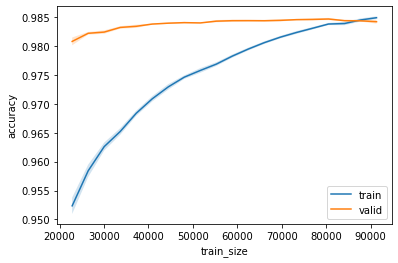

In [46]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

нет, потому что для достижения нужной точности всё равно приходится обрабатывать все данные

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.